In [1]:
import pandas as pd
import pickle 
import json
import cv2
import matplotlib.pyplot as plt
import TransformHelper

In [2]:
def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data
def read_normalized_json_to_df(filepath):
    full_file_df = ""
    with open(filepath, 'r', encoding="utf-8") as json_file:
        json_full = json.load(json_file)
    full_file_df = pd.json_normalize(json_full)
    return full_file_df

In [3]:
json_path = "./AllBuildingList_TaskAssignment.json"

# Load transformation info 
transform_infos = load_from_disk("./map_image_transform_infos.pickle")
transform_matrix = transform_infos["perspective_transform_matrix"]
image_size = transform_infos["image_size"]

In [4]:
# TODO 
# "church"
# 'building01_LOD0', 'building01_LOD1', 'building02_LOD0'

## Convention

Building names list contains 
* Actual buildings (e.g. "Building_abc")
* Task buildings (e.g. "TaskBuilding_ab")
* Pre-defined Landmarks (e.g. "Castle-TaskBuilding_56")
* Cranes (e.g. crane_a)
* Garages (e.g. "Garage_abc")

Actual buildings: Are filtered such that their name appears only once in the building list. Some buildings have multiple colliders (connected to the same building name), use the mean of those for plotting purposes. 

Task buildings: Names are included as they are in the list. 

Pre-defined landmarks: Names are included as they are in the list. 

Cranes: Collider names are filtered out from measurement data and added to the list.

Garages: Some garages are treated as seperate buildings, some are considered as part of the building they are close to. Specifically, Garage_235, Garage_224, Garage_185, Garage_98, Garage_86 are seperate buildings and treated as such; Garage_72, Garage_71, Garage_46, Garage_26 are treated as belonging to the buildings with the same numbers, i.e. those garages are renamed (e.g. Garage_72 becomes Building_72). 

Since the JSON that provides the building names and information holds different data than was actually measured (potentially due to different pivot points of the buildings, e.g. corner vs center of mass), the positions are extracted from the actual measurement data. 


## Building JSON

### Load file

In [5]:
# Read all buildings from the buildings json file 
nonunique_buildings_df = read_normalized_json_to_df(json_path)
print("Non-unique building names as provided by the building JSON:")
print(list(nonunique_buildings_df["BuildingName"]))
print()
print("Unique building names as provided by the building JSON:")
print(list(set(list(nonunique_buildings_df["BuildingName"]))))
print()
print("Number of nun-unique JSON building entries: " + str(len(list(nonunique_buildings_df["BuildingName"]))))
print("Number of unique JSON building entries: " + str(len(list(set(list(nonunique_buildings_df["BuildingName"]))))))


Non-unique building names as provided by the building JSON:
['Building_92', 'Garage_224', 'Building_226', 'Building_58', 'Building_182', 'Building_101', 'Building_225', 'Building_105', 'Building_139', 'Building_161', 'Garage_185', 'Building_146', 'Building_229', 'Building_86', 'Building_216', 'Building_215', 'Building_175', 'Building_196', 'Building_228', 'Building_124', 'Building_115', 'Building_192', 'Building_174', 'Building_219', 'Building_213', 'Building_192', 'Building_116', 'Building_116', 'Building_115', 'Building_189', 'Building_207', 'Building_193', 'Building_158', 'Building_123', 'Building_154', 'Building_125', 'Building_206', 'Building_191', 'Building_212', 'Building_190', 'Building_151', 'Building_84', 'Building_122', 'Building_106', 'Garage_185', 'Building_198', 'Building_131', 'Building_179', 'Building_201', 'Building_165', 'Building_184', 'Building_171', 'Building_176', 'Building_177', 'Building_208', 'Building_185', 'Building_178', 'Building_121', 'Building_157', 'Buil

### Find buildings with multiple different colliders (from building JSON)

In [6]:
# Group by BuildingName 
building_cnt_df = nonunique_buildings_df.groupby("BuildingName").count()

print("Buildings of the same name with multiple different positions (from buildings JSON):")
print(building_cnt_df.loc[building_cnt_df["BuildingID"] != 1]["BuildingID"].sort_index())
print()
#print("Colliders of those buildings (from buildings JSON):")
#nonunique_buildings_df.loc[nonunique_buildings_df["BuildingName"].isin(building_cnt_df.loc[building_cnt_df["BuildingID"] != 1].reset_index()["BuildingName"])].sort_values("BuildingName")

Buildings of the same name with multiple different positions (from buildings JSON):
BuildingName
Building_115     2
Building_116     2
Building_183     2
Building_192     2
Garage_185      16
Garage_224       4
Garage_235       8
Garage_46        3
Garage_86        4
Garage_98        4
Name: BuildingID, dtype: int64



## Measurement Data

### Find additional buildings (from measurement data)

In [7]:
# unique building names in json file 
building_names_json = nonunique_buildings_df.groupby("BuildingName").count().reset_index().drop_duplicates("BuildingName")["BuildingName"].to_numpy()
building_names_json = list(building_names_json)

# load measurement data 
measurement_df = pd.read_csv("./../Results/1023_CompleteExploration_Hitpoints.csv")
#measurement_df.loc[measurement_df["hitObjectColliderName"].str.contains("crane")].groupby("hitObjectColliderName").count()

# find all collider-names in measurement data 
all_colliders_measurement = measurement_df.groupby("hitObjectColliderName").count().reset_index().drop_duplicates("hitObjectColliderName")["hitObjectColliderName"]
#all_colliders_measurement.to_csv("./pre/all_unique_colliders_1023_exploration.csv")

# filter for buildings 
filter_str = "(?i)house|building|garage|crane|church" # re (?i) ignores case
measurement_df_only_buildings = measurement_df.loc[measurement_df["hitObjectColliderName"].str.contains((filter_str))] 
measurement_df_only_buildings_list = measurement_df_only_buildings.groupby("hitObjectColliderName").count().reset_index().drop_duplicates("hitObjectColliderName")["hitObjectColliderName"]

# Show buildings with multiple colliders 
building_cnt_measurement_df = measurement_df_only_buildings.groupby(["hitObjectColliderName","hitObjectColliderBoundsCenter.x","hitObjectColliderBoundsCenter.y","hitObjectColliderBoundsCenter.z"]).count()
building_cnt_measurement_df = building_cnt_measurement_df.reset_index().groupby("hitObjectColliderName").count()
print("Buildings of the same name with multiple different positions (from measurements):")
print(building_cnt_measurement_df.loc[building_cnt_measurement_df["hitObjectColliderBoundsCenter.x"] != 1]["hitObjectColliderBoundsCenter.x"].sort_index())
print()


# difference between json building names and measurement building names
print("Difference between JSON's building names and measurement building names")
print("Not in measurement: " + str(list(set(building_names_json) - set(measurement_df_only_buildings_list))))
print("Not in JSON: " + str(list(set(measurement_df_only_buildings_list) - set(building_names_json))))



Buildings of the same name with multiple different positions (from measurements):
hitObjectColliderName
Building_115    2
Building_116    2
Building_174    2
Building_183    2
Building_192    3
Building_193    3
Building_205    3
Garage_185      9
Garage_224      4
Garage_235      8
Garage_46       3
Garage_86       4
Garage_98       4
crane_1         3
crane_2         2
Name: hitObjectColliderBoundsCenter.x, dtype: int64

Difference between JSON's building names and measurement building names
Not in measurement: ['Building_191', 'Church-TaskBuilding_16']
Not in JSON: ['crane_1', 'building02_LOD0', 'building01_LOD0', 'crane_2', 'church', 'building01_LOD1']


### Create average building positions (from measurement data)

In [8]:

# group by position and delete unnecessary infos 
average_building_positions = measurement_df_only_buildings.groupby(["hitObjectColliderName","hitObjectColliderBoundsCenter.x","hitObjectColliderBoundsCenter.y","hitObjectColliderBoundsCenter.z"]).count().drop(columns=["timeStampDataPointStart","timeStampDataPointEnd","ordinalOfHit","hitPointOnObject.x","hitPointOnObject.y","hitPointOnObject.z"])

# remove unnamed column 
average_building_positions = average_building_positions.loc[:, ~average_building_positions.columns.str.contains('^Unnamed')]

# group by collider name and average positions
average_building_positions = average_building_positions.reset_index().groupby("hitObjectColliderName").mean().reset_index()


### Manually add missing buildings from the building JSON list to the building positions list 

In [9]:

# add ['Building_191', 'Church-TaskBuilding_16']
for building_name in ['Building_191', 'Church-TaskBuilding_16']:
    curr_df = nonunique_buildings_df.loc[nonunique_buildings_df["BuildingName"] == building_name]
    average_building_positions.loc[len(average_building_positions)]= [curr_df["BuildingName"].item(),curr_df["BuildingPosition.x"].item(),curr_df["BuildingPosition.y"].item(),curr_df["BuildingPosition.z"].item()]
average_building_positions


,hitObjectColliderName,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z
0,Building_100,27.202402,4.637518,66.574875
1,Building_101,29.179993,9.017884,109.739998
2,Building_102,10.699999,9.022681,135.199997
3,Building_103,44.767456,6.790395,161.120209
4,Building_104,148.502731,5.281566,50.124672
...,...,...,...,...
248,church,280.184875,19.870625,-90.926231
249,crane_1,-101.114072,19.279706,-24.529291
250,crane_2,-317.305069,25.279850,-164.529755
251,Building_191,-363.551361,3.137159,151.427521


## Comparison between building JSON and measurements

### Compare JSON building positions and building positions of the measurements

In [10]:

unique_json_df = nonunique_buildings_df.copy(deep=True)
unique_json_df = unique_json_df.drop_duplicates("BuildingName", keep="first")
#print(unique_json_df)

# construct comparison df by going row by row 
compare_df = pd.DataFrame(columns=["Name","x_diff","y_diff","z_diff"])
for index, row in average_building_positions.iterrows(): 
    try:
        building_name = row["hitObjectColliderName"]
        average_x = row["hitObjectColliderBoundsCenter.x"] # from measurements
        average_y = row["hitObjectColliderBoundsCenter.y"]
        average_z = row["hitObjectColliderBoundsCenter.z"]
        json_x = unique_json_df.loc[unique_json_df["BuildingName"] == building_name]["BuildingPosition.x"].item() # from json
        json_y = unique_json_df.loc[unique_json_df["BuildingName"] == building_name]["BuildingPosition.y"].item()
        json_z = unique_json_df.loc[unique_json_df["BuildingName"] == building_name]["BuildingPosition.z"].item()
        compare_df.loc[len(compare_df)]= [building_name,average_x-json_x,average_y-json_y,average_z-json_z]
    except:
        print("No comparison for " + str(row["hitObjectColliderName"]))



No comparison for building01_LOD0
No comparison for building01_LOD1
No comparison for building02_LOD0
No comparison for church
No comparison for crane_1
No comparison for crane_2


In [11]:
compare_df = compare_df.copy(deep=True)
compare_df.sort_values(by=["x_diff"],ascending=False)

,Name,x_diff,y_diff,z_diff
30,Building_130,18.086563,5.569539,7.273010
160,Building_81,17.265350,7.994967,-9.531235
179,Castle-TaskBuilding_56,16.638947,10.727325,-12.788910
148,Building_69,16.422668,6.416393,9.991150
156,Building_77,16.357849,6.416391,-10.096893
...,...,...,...,...
102,Building_203,-15.001312,10.106288,4.128979
108,Building_209,-15.156006,7.501360,12.101845
125,Building_226,-18.210665,5.890927,-3.258820
135,Building_236,-20.233902,2.992148,0.432289


In [12]:
compare_df.sort_values("y_diff",ascending=False)


,Name,x_diff,y_diff,z_diff
36,Building_136,-2.354431e-02,15.805426,-9.210205e-02
244,Windmill-TaskBuilding_10_1,-5.785522e-01,15.242785,-1.168976e-01
113,Building_214,-1.026134e+01,15.183289,-1.178544e+01
189,HighSilo-TaskBuilding_49,-1.020068e+01,14.588898,1.680725e+01
10,Building_110,-2.842171e-14,11.840600,9.536743e-07
...,...,...,...,...
246,Church-TaskBuilding_16,0.000000e+00,0.000000,0.000000e+00
75,Building_175,-9.902954e-03,-0.000002,-9.845734e-03
74,Building_174,-2.160301e+00,-1.298942,5.455490e+00
154,Building_75,-3.614044e+00,-2.825732,-1.155710e+01


In [13]:
compare_df.sort_values("z_diff",ascending=False)

,Name,x_diff,y_diff,z_diff
29,Building_129,7.519913,3.689011,34.770432
161,Building_82,9.531219,7.994972,17.265358
189,HighSilo-TaskBuilding_49,-10.200684,14.588898,16.807251
108,Building_209,-15.156006,7.501360,12.101845
144,Building_65,9.524353,3.155003,10.439781
...,...,...,...,...
156,Building_77,16.357849,6.416391,-10.096893
190,House_10,1.153992,9.146853,-10.567078
154,Building_75,-3.614044,-2.825732,-11.557098
113,Building_214,-10.261337,15.183289,-11.785442


## Save building positions 

### Create naming dictionary including renaming

In [14]:
building_positions_dict = {}

# Rename garages that belong to buildings 
# Garage_72, Garage_71, Garage_46, Garage_26 
renaming_dict = {}
renaming_dict["Garage_72"] = "Building_72"
renaming_dict["Garage_71"] = "Building_71"
renaming_dict["Garage_46"] = "TaskBuilding_46"
renaming_dict["Garage_26"] = "TaskBuilding_26"

for index, row in average_building_positions.iterrows():
    name = row["hitObjectColliderName"]   
    
    if name in renaming_dict.keys(): # look up item that should be placed instead of renamed
        x = average_building_positions.loc[average_building_positions["hitObjectColliderName"] == renaming_dict[name]]["hitObjectColliderBoundsCenter.x"].item()
        y = average_building_positions.loc[average_building_positions["hitObjectColliderName"] == renaming_dict[name]]["hitObjectColliderBoundsCenter.y"].item()
        z = average_building_positions.loc[average_building_positions["hitObjectColliderName"] == renaming_dict[name]]["hitObjectColliderBoundsCenter.z"].item()
    else: # no renaming 
        x = row["hitObjectColliderBoundsCenter.x"]
        y = row["hitObjectColliderBoundsCenter.y"]
        z = row["hitObjectColliderBoundsCenter.z"]
    
    building_positions_dict[name] = {} # possible overwriting of key due to renaming is ok, values will be the same 
    building_positions_dict[name]["ColliderBoundsCenter.x"] = x
    building_positions_dict[name]["ColliderBoundsCenter.y"] = y
    building_positions_dict[name]["ColliderBoundsCenter.z"] = z
    
    # calculate perspective transform and store 
    (transformed_x,transformed_y) = TransformHelper.apply_perspective_transform_matrix(transform_matrix,img_size=(4096,4096),pixel_coords=(x,z))
    building_positions_dict[name]["transformed_collidercenter_x"] = transformed_x
    building_positions_dict[name]["transformed_collidercenter_y"] = transformed_y



#print(building_positions_dict)

    

Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
Calculating Perspective Transform...
C

In [15]:
# save to disk 
save_to_disk(building_positions_dict,"./building_renaming_positions.pickle")

## Plot for sanity purposes

### Plot buildings JSON vs buildings from measurements

In [16]:
# Apply transformation for JSON building data
unique_json_df = TransformHelper.apply_perspective_transform_matrix(transform_matrix,img_size=image_size,dataframe=unique_json_df,df_x_name="BuildingPosition.x",df_y_name="BuildingPosition.z",transform_x_name="transformed_buildingposition_x",transform_y_name="transformed_buildingposition_y")

Calculating Perspective Transform...


100%|██████████| 247/247 [00:00<00:00, 4576.71it/s]


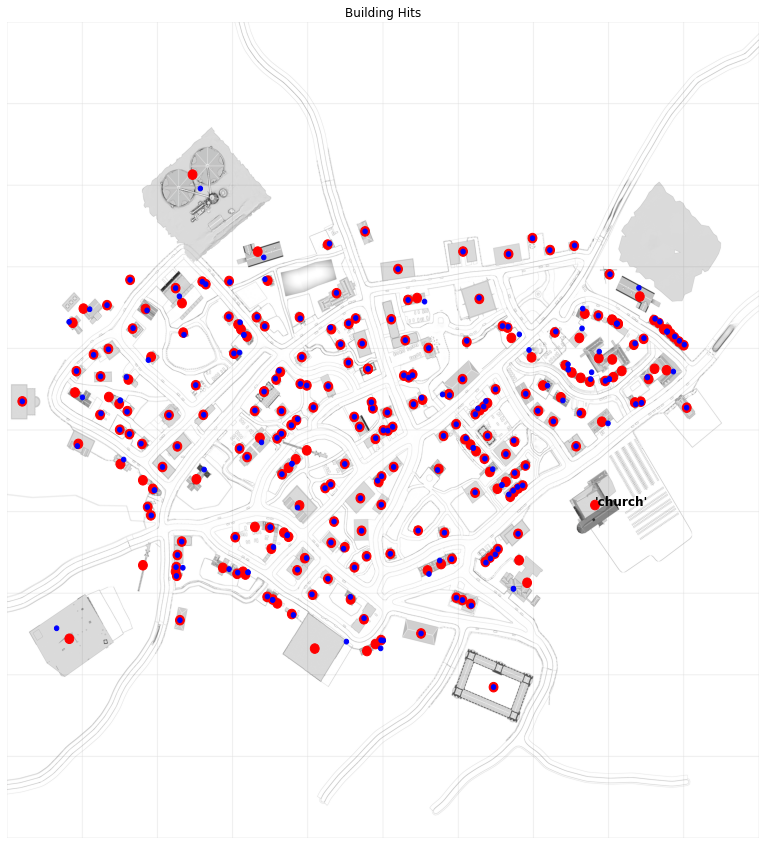

'\n# color bar on the side \na=np.outer(np.arange(0,1,0.01),np.ones(3))\nax2 = plt.subplot2grid((10, 10), (1, 9),rowspan=8)\nplt.imshow(a,aspect=\'auto\',cmap=\'Blues\',origin="lower")\nax2.get_xaxis().set_ticks([])\nax2.get_yaxis().set_ticks(np.linspace(0,99,10))\n#ax2.get_yaxis().set_ticklabels(np.linspace(min_hits // 10 * 10,max_hits // 10 * 10,10,dtype=int))\nax2.yaxis.tick_right()\nax2.set_ylabel("Number of Eye Tracking hits on a building",rotation=270,labelpad=20) # fontsize\nax2.yaxis.set_label_position("right")\nplt.show()\n'

In [17]:
# Read bg image
white_bg_img = cv2.imread("./map_white.png")


# plot
fig = plt.figure(figsize=(15,15))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.title("Buildings", fontsize = 20)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1)


# add circles to map 
circle_size_measurement = 24
circle_size_json = 12
circle_color_measurement = "Red"
circle_color_json = "Blue"
circles_measurement = [] 
circles_json = [] 

for idx, key in enumerate(building_positions_dict.keys()):
    circles_measurement.append(plt.Circle((building_positions_dict[key]["transformed_collidercenter_x"],building_positions_dict[key]["transformed_collidercenter_y"]),circle_size_measurement,color=circle_color_measurement,zorder=2))
    ax.add_artist(circles_measurement[idx]) 
                   
for idx, row in unique_json_df.reset_index().iterrows():  
    circles_json.append(plt.Circle((row["transformed_buildingposition_x"],row["transformed_buildingposition_y"]),circle_size_json,color = circle_color_json,zorder=3))
    ax.add_artist(circles_json[idx])  
    


plt.text(building_positions_dict["church"]["transformed_collidercenter_x"], building_positions_dict["church"]["transformed_collidercenter_y"],"'church'",size="large",fontweight="bold")

plt.title("Building Hits") # fontsize
plt.show()

'''
# color bar on the side 
a=np.outer(np.arange(0,1,0.01),np.ones(3))
ax2 = plt.subplot2grid((10, 10), (1, 9),rowspan=8)
plt.imshow(a,aspect='auto',cmap='Blues',origin="lower")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks(np.linspace(0,99,10))
#ax2.get_yaxis().set_ticklabels(np.linspace(min_hits // 10 * 10,max_hits // 10 * 10,10,dtype=int))
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of Eye Tracking hits on a building",rotation=270,labelpad=20) # fontsize
ax2.yaxis.set_label_position("right")
plt.show()
'''